In [1]:
#Created: Brandon Tran
#Description: Analysing the output from dumpGpuPower over the AccelWattch validation kernels
# the hope is to determine a consistent warmup period before getting stable power/temp readings
# Note dumpGpuPower was used in conjuction with profile_temp_power.sh run from a modified run_batch_power_validation.sh

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Define your custom color palette
custom_colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9', '#E69F00']

# Set the custom color palette using set_prop_cycle
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=custom_colors)

In [3]:
def process_output_lines(line_list):
    output_dict ={}
    benchmark = ""
    current_benchmark=""
    for line in line_list:
        # print(line.strip())
        #Ignore lines that mention kills
        if "Kill" in line or "Sleep" in line:
            continue
        #Use this to grab the benchmark name
        if 'Starting' in line:
            current_benchmark = line.split()[3]
            # print(current_benchmark)
        #If Working with the new benchmark setup list
        if current_benchmark != benchmark and current_benchmark not in output_dict:
            benchmark = current_benchmark
            output_dict[current_benchmark] = []
        #Get start/end temps
        if "Temperature" in line:
            output_dict[current_benchmark].append(int(line.split()[3]))
    
    for bench in output_dict:
        if len(output_dict[bench])%2 != 0:
               raise ValueError("Did not get even number of temperatures for {}".format(bench))
        output_dict[bench] = [(output_dict[bench][i],output_dict[bench][i+1]) for i in range(0,len(output_dict[bench]),2)] 
    return output_dict

def process_output_file(file):
    benchmark_dict = {}
    # print(file)
    with open(file) as f:
        lines = f.readlines()
    # print(lines)
    start_text_list = ['RUNNING POWER/TEMP DUMP WITH ONLY SLEEPS\n','RUNNING POWER/TEMP DUMP WITH WARMUPS AND SLEEPS\n','RUNNING POWER/TEMP DUMP WITH WARMUP NO SLEEP\n']
    boolean_does_exist = []
    start_index_list = []
    for text in start_text_list:
        if text in lines:
            start_index_list.append(lines.index(text))
        else:
            start_index_list.append(-1)
    # print(start_index_list)
    #Now that we have the indices, let's get the kernel_sleep/warm: (start temp, end temp)
    # 'Starting execution of kmeans_k1 \n',
    # 'Temperature is currently 32 C\n',
    # 'Starting profiling of kmeans_k1 \n',
    # 'Profiling concluded. Killing kmeans_k1 with pid: 660512\n',
    # 'Temperature is currently 43 C\n',
    # 'Sleeping...\n',

    if start_index_list[0] != -1 and start_index_list[2] != -1:
        header="no_warmup_sleep"
        no_warmup_sleep_dict = process_output_lines(lines[start_index_list[0]+1:start_index_list[1]])
        for benchmark in no_warmup_sleep_dict:
            benchmark_dict["{}_{}".format(benchmark,header)]=no_warmup_sleep_dict[benchmark]
        header="warmup_no_sleep"
        warmup_no_sleep_dict = process_output_lines(lines[start_index_list[2]+1:])
        for benchmark in warmup_no_sleep_dict:
            benchmark_dict["{}_{}".format(benchmark,header)]=warmup_no_sleep_dict[benchmark]    
        header="warmup_sleep"
        warmup_sleep_dict = process_output_lines(lines[start_index_list[1]+1:start_index_list[2]])
        for benchmark in warmup_sleep_dict:
            benchmark_dict["{}_{}".format(benchmark,header)]=warmup_sleep_dict[benchmark]    
    else:
        header="warmup_sleep"
        warmup_sleep_dict = process_output_lines(lines)
        for benchmark in warmup_sleep_dict:
            benchmark_dict["{}_{}".format(benchmark,header)]=warmup_sleep_dict[benchmark]    
        
    return benchmark_dict

In [4]:
# process_output_file("/gpfs/alpine/gen150/scratch/brantran/accelwattch-artifact-appendix/accel-sim-framework/logs/temp_power_util3/AccelWattch_validation.3035986")

In [5]:
cwd = os.getcwd()
cwd = os.path.join(cwd,"logs","temp_power_util3")
keyword="AccelWattch_validation"
output_files = [os.path.join(cwd,file) for file in os.listdir(cwd) if keyword in file]
power_temp_dump_dir = cwd#os.path.join(cwd,"accelwattch_hw_profiler","power_temp_output")
output_files

['/gpfs/alpine/gen150/scratch/brantran/accelwattch-artifact-appendix/accel-sim-framework/logs/temp_power_util3/AccelWattch_validation.3035986',
 '/gpfs/alpine/gen150/scratch/brantran/accelwattch-artifact-appendix/accel-sim-framework/logs/temp_power_util3/AccelWattch_validation.3035983',
 '/gpfs/alpine/gen150/scratch/brantran/accelwattch-artifact-appendix/accel-sim-framework/logs/temp_power_util3/AccelWattch_validation.3035979',
 '/gpfs/alpine/gen150/scratch/brantran/accelwattch-artifact-appendix/accel-sim-framework/logs/temp_power_util3/AccelWattch_validation.3035984',
 '/gpfs/alpine/gen150/scratch/brantran/accelwattch-artifact-appendix/accel-sim-framework/logs/temp_power_util3/AccelWattch_validation.3035982',
 '/gpfs/alpine/gen150/scratch/brantran/accelwattch-artifact-appendix/accel-sim-framework/logs/temp_power_util3/AccelWattch_validation.3035987',
 '/gpfs/alpine/gen150/scratch/brantran/accelwattch-artifact-appendix/accel-sim-framework/logs/temp_power_util3/AccelWattch_validation.30

In [6]:
benchmark_external_temps={}
for file in output_files:
    benchmark_external_temps.update(process_output_file(file))
benchmark_external_temps

{'dct8x8_k1_no_warmup_sleep': [(31, 38),
  (32, 38),
  (32, 39),
  (31, 38),
  (32, 39)],
 'dct8x8_k2_no_warmup_sleep': [(32, 39),
  (32, 38),
  (31, 38),
  (32, 39),
  (32, 39)],
 'cutlass_k1_no_warmup_sleep': [(32, 37),
  (32, 37),
  (31, 37),
  (32, 37),
  (32, 37)],
 'dct8x8_k1_warmup_no_sleep': [(31, 38),
  (37, 39),
  (37, 39),
  (37, 39),
  (37, 39)],
 'dct8x8_k2_warmup_no_sleep': [(38, 39),
  (39, 39),
  (39, 39),
  (39, 38),
  (39, 39)],
 'cutlass_k1_warmup_no_sleep': [(38, 37),
  (38, 37),
  (39, 37),
  (38, 37),
  (38, 37)],
 'dct8x8_k1_warmup_sleep': [(31, 38), (32, 39), (31, 38), (31, 38), (32, 38)],
 'dct8x8_k2_warmup_sleep': [(32, 39), (32, 38), (31, 38), (32, 38), (31, 38)],
 'cutlass_k1_warmup_sleep': [(32, 37), (32, 37), (32, 37), (32, 37), (32, 37)],
 'parboil_mriq_k1_no_warmup_sleep': [(30, 48),
  (31, 50),
  (31, 49),
  (31, 50),
  (31, 49)],
 'parboil_sad_k1_no_warmup_sleep': [(31, 42),
  (31, 43),
  (31, 42),
  (31, 43),
  (31, 43)],
 'parboil_sgemm_k1_no_warmup_

In [7]:
def process_dump_file(path,NUM_SAMPLES=600):
    output_list = []
    # print(path)
    with open(path,encoding='utf-8') as f:
        lines = f.readlines()
    power_list=[]
    temp_list=[]
    util_list=[]
    raw_power_list=[]
    raw_temp_list=[]
    prev_index = 0
    run_num = 0;
    run_dict = {}
    for line in lines:
        if not line.startswith('['):
            continue
        # print(line.strip())
        splits = line.strip().split()
        index=int(splits[0].replace('[','').replace(']',''))
        power = splits[2].replace(',','')
        temp = splits[-1]
        if len(splits) > 6:
            util = int(splits[4])

        #     print(index,power,util,temp)
        # else:
        #     print(index,power,temp)
        #prev = 599, index = 0 => (reset)
        if index < prev_index:
            run_dict["run"] = run_num
            if len(power_list) != len(temp_list) or len(power_list) != NUM_SAMPLES or len(temp_list) != NUM_SAMPLES:
                raise ValueError("Something went wrong processing the dump files:lengths=(power: {},temp: {})",format(len(power_list),len(temp_list)))
            run_dict["raw_power"] = power_list.copy()
            run_dict["raw_temp"] = temp_list.copy()
            run_dict["power"] = [float(value) if value != "util" else -1 for value in power_list]
            run_dict["temp"] = [int(temp_value) if power_value != "util" else -1 for power_value,temp_value in zip(power_list,temp_list)]
            run_dict["util"] = util_list.copy()
            power_list = []
            temp_list = []
            util_list = []
            run_num += 1
            output_list.append(run_dict)
            run_dict={}
        power_list.append(power)
        temp_list.append(temp)
        prev_index = index
        if len(splits) > 6:
            util_list.append(util)

    #Do the process one last time
    run_dict["run"] = run_num
    run_dict["raw_power"] = power_list.copy()
    run_dict["raw_temp"] = temp_list.copy()
    run_dict["power"] = [float(value) if value != "util" else -1 for value in power_list]
    run_dict["temp"] = [int(temp_value) if power_value != "util" else -1 for power_value,temp_value in zip(power_list,temp_list)]
    run_dict["util"] = util_list.copy()
    output_list.append(run_dict)
    # print(output_list)
    return output_list

In [8]:
file = "dct8x8_k2_no_warmup_sleep"+".txt"
process_dump_file(os.path.join(power_temp_dump_dir,file))[0]

{'run': 0,
 'raw_power': ['36.2540',
  '36.2540',
  '36.2540',
  '36.2540',
  '36.2540',
  '36.2540',
  '36.2540',
  '36.2540',
  '36.2540',
  '51.4080',
  '52.3870',
  '91.9240',
  '105.0570',
  '113.3640',
  '118.6610',
  '120.1260',
  '122.0800',
  '124.0330',
  '125.0090',
  '125.0090',
  '125.4980',
  '125.4980',
  '125.0090',
  '125.4980',
  '125.9860',
  '125.4980',
  '125.4980',
  '126.4740',
  '125.4980',
  '125.9860',
  '126.4740',
  '125.4980',
  '125.4980',
  '126.9630',
  '125.9860',
  '125.0090',
  '125.9860',
  '126.4740',
  '125.4980',
  '125.9860',
  '126.4740',
  '125.9860',
  '125.9860',
  '126.4740',
  '125.9860',
  '125.9860',
  '126.4740',
  '125.9860',
  '125.9860',
  '126.4740',
  '125.9860',
  '124.5210',
  '125.9860',
  '126.9630',
  '125.9860',
  '125.9860',
  '126.4740',
  '125.9860',
  '125.9860',
  '126.4740',
  '125.9860',
  '125.9860',
  '126.4740',
  '125.9860',
  '125.9860',
  '126.4740',
  '125.9860',
  '125.9860',
  '126.4740',
  '125.0090',
  '125.9

In [9]:


benchmark_dump = {}
benchmark_dump['_no_warmup_sleep'] = {}
benchmark_dump['_warmup_sleep'] = {}
benchmark_dump['_warmup_no_sleep'] = {}

for file in os.listdir(power_temp_dump_dir):
    if file == "output.txt":
        continue
    benchmark_set, ext = os.path.splitext(file)
    if ext == '.txt':
        if '_no_' not in benchmark_set:
            benchmark_dump['_warmup_sleep'][benchmark_set] = process_dump_file(os.path.join(power_temp_dump_dir,file))
        if 'no_warmup' in benchmark_set:
            benchmark_dump['_no_warmup_sleep'][benchmark_set] = process_dump_file(os.path.join(power_temp_dump_dir,file))
        if 'no_sleep' in benchmark_set:
            benchmark_dump['_warmup_no_sleep'][benchmark_set] = process_dump_file(os.path.join(power_temp_dump_dir,file))


In [10]:
benchmark_dump['_no_warmup_sleep'].keys()

dict_keys(['fastWalshTransform_k1_no_warmup_sleep', 'dct8x8_k1_no_warmup_sleep', 'histogram_k1_no_warmup_sleep', 'backprop_k2_no_warmup_sleep', 'pathfinder_k1_no_warmup_sleep', 'parboil_sad_k1_no_warmup_sleep', 'mergeSort_k1_no_warmup_sleep', 'cutlass_k2_no_warmup_sleep', 'dct8x8_k2_no_warmup_sleep', 'backprop_k1_no_warmup_sleep', 'btree_k1_no_warmup_sleep', 'sobolQRNG_k1_no_warmup_sleep', 'parboil_sgemm_k1_no_warmup_sleep', 'cudaTensorCoreGemm_k1_no_warmup_sleep', 'quasirandomGenerator_k1_no_warmup_sleep', 'kmeans_k1_no_warmup_sleep', 'cutlass_k3_no_warmup_sleep', 'cutlass_k1_no_warmup_sleep', 'hotspot_k1_no_warmup_sleep', 'parboil_mriq_k1_no_warmup_sleep', 'fastWalshTransform_k2_no_warmup_sleep', 'quasirandomGenerator_k2_no_warmup_sleep', 'srad_v1_k1_no_warmup_sleep', 'binomialOptions_k1_no_warmup_sleep', 'mergeSort_k2_no_warmup_sleep', 'btree_k2_no_warmup_sleep'])

In [11]:
header = '_no_warmup_sleep'
benchmark_list = [benchmark.replace(header,'') for benchmark in benchmark_dump[header]]


In [12]:
benchmark_dump[header].keys()

dict_keys(['fastWalshTransform_k1_no_warmup_sleep', 'dct8x8_k1_no_warmup_sleep', 'histogram_k1_no_warmup_sleep', 'backprop_k2_no_warmup_sleep', 'pathfinder_k1_no_warmup_sleep', 'parboil_sad_k1_no_warmup_sleep', 'mergeSort_k1_no_warmup_sleep', 'cutlass_k2_no_warmup_sleep', 'dct8x8_k2_no_warmup_sleep', 'backprop_k1_no_warmup_sleep', 'btree_k1_no_warmup_sleep', 'sobolQRNG_k1_no_warmup_sleep', 'parboil_sgemm_k1_no_warmup_sleep', 'cudaTensorCoreGemm_k1_no_warmup_sleep', 'quasirandomGenerator_k1_no_warmup_sleep', 'kmeans_k1_no_warmup_sleep', 'cutlass_k3_no_warmup_sleep', 'cutlass_k1_no_warmup_sleep', 'hotspot_k1_no_warmup_sleep', 'parboil_mriq_k1_no_warmup_sleep', 'fastWalshTransform_k2_no_warmup_sleep', 'quasirandomGenerator_k2_no_warmup_sleep', 'srad_v1_k1_no_warmup_sleep', 'binomialOptions_k1_no_warmup_sleep', 'mergeSort_k2_no_warmup_sleep', 'btree_k2_no_warmup_sleep'])

<h1>Visualization</h1>

In [13]:
benchmark = benchmark_list[5]
header='_no_warmup_sleep'
all_benchmark_data=benchmark_dump[header]
benchmark_data = all_benchmark_data[benchmark+header]
for data_dict in benchmark_data:
    print("power",data_dict['power'][:10])
    print("temp",data_dict['temp'][:10])
    print("util",data_dict['util'][:10])

power [35.764, 35.764, 53.856, 122.648, 142.496, 145.912, 165.323, 168.249, 169.224, 166.298]
temp [31, 31, 31, 33, 34, 35, 36, 36, 37, 37]
util [0, 0, 0, 15, 100, 100, 100, 100, 100, 100]
power [39.193, 119.228, 142.984, 145.424, 166.298, 166.298, 166.298, 168.249, 169.224, 169.712]
temp [31, 33, 34, 35, 36, 36, 37, 37, 37, 38]
util [1, 1, 80, 80, 100, 100, 100, 100, 100, 100]
power [44.582, 122.08, 145.912, 146.888, 165.811, 168.737, 169.224, 169.224, 169.224, 167.274]
temp [31, 33, 34, 35, 36, 36, 37, 37, 37, 38]
util [1, 1, 71, 71, 100, 100, 100, 100, 100, 100]
power [44.092, 121.671, 122.568, 144.448, 163.372, 165.811, 169.224, 169.224, 169.224, 169.224]
temp [31, 33, 34, 35, 36, 36, 37, 37, 38, 38]
util [0, 13, 13, 100, 100, 100, 100, 100, 100, 100]
power [38.703, 121.103, 143.96, 146.4, 166.298, 165.811, 168.737, 169.224, 169.712, 169.224]
temp [31, 33, 34, 35, 36, 36, 37, 37, 38, 38]
util [1, 1, 75, 75, 100, 100, 100, 100, 100, 100]


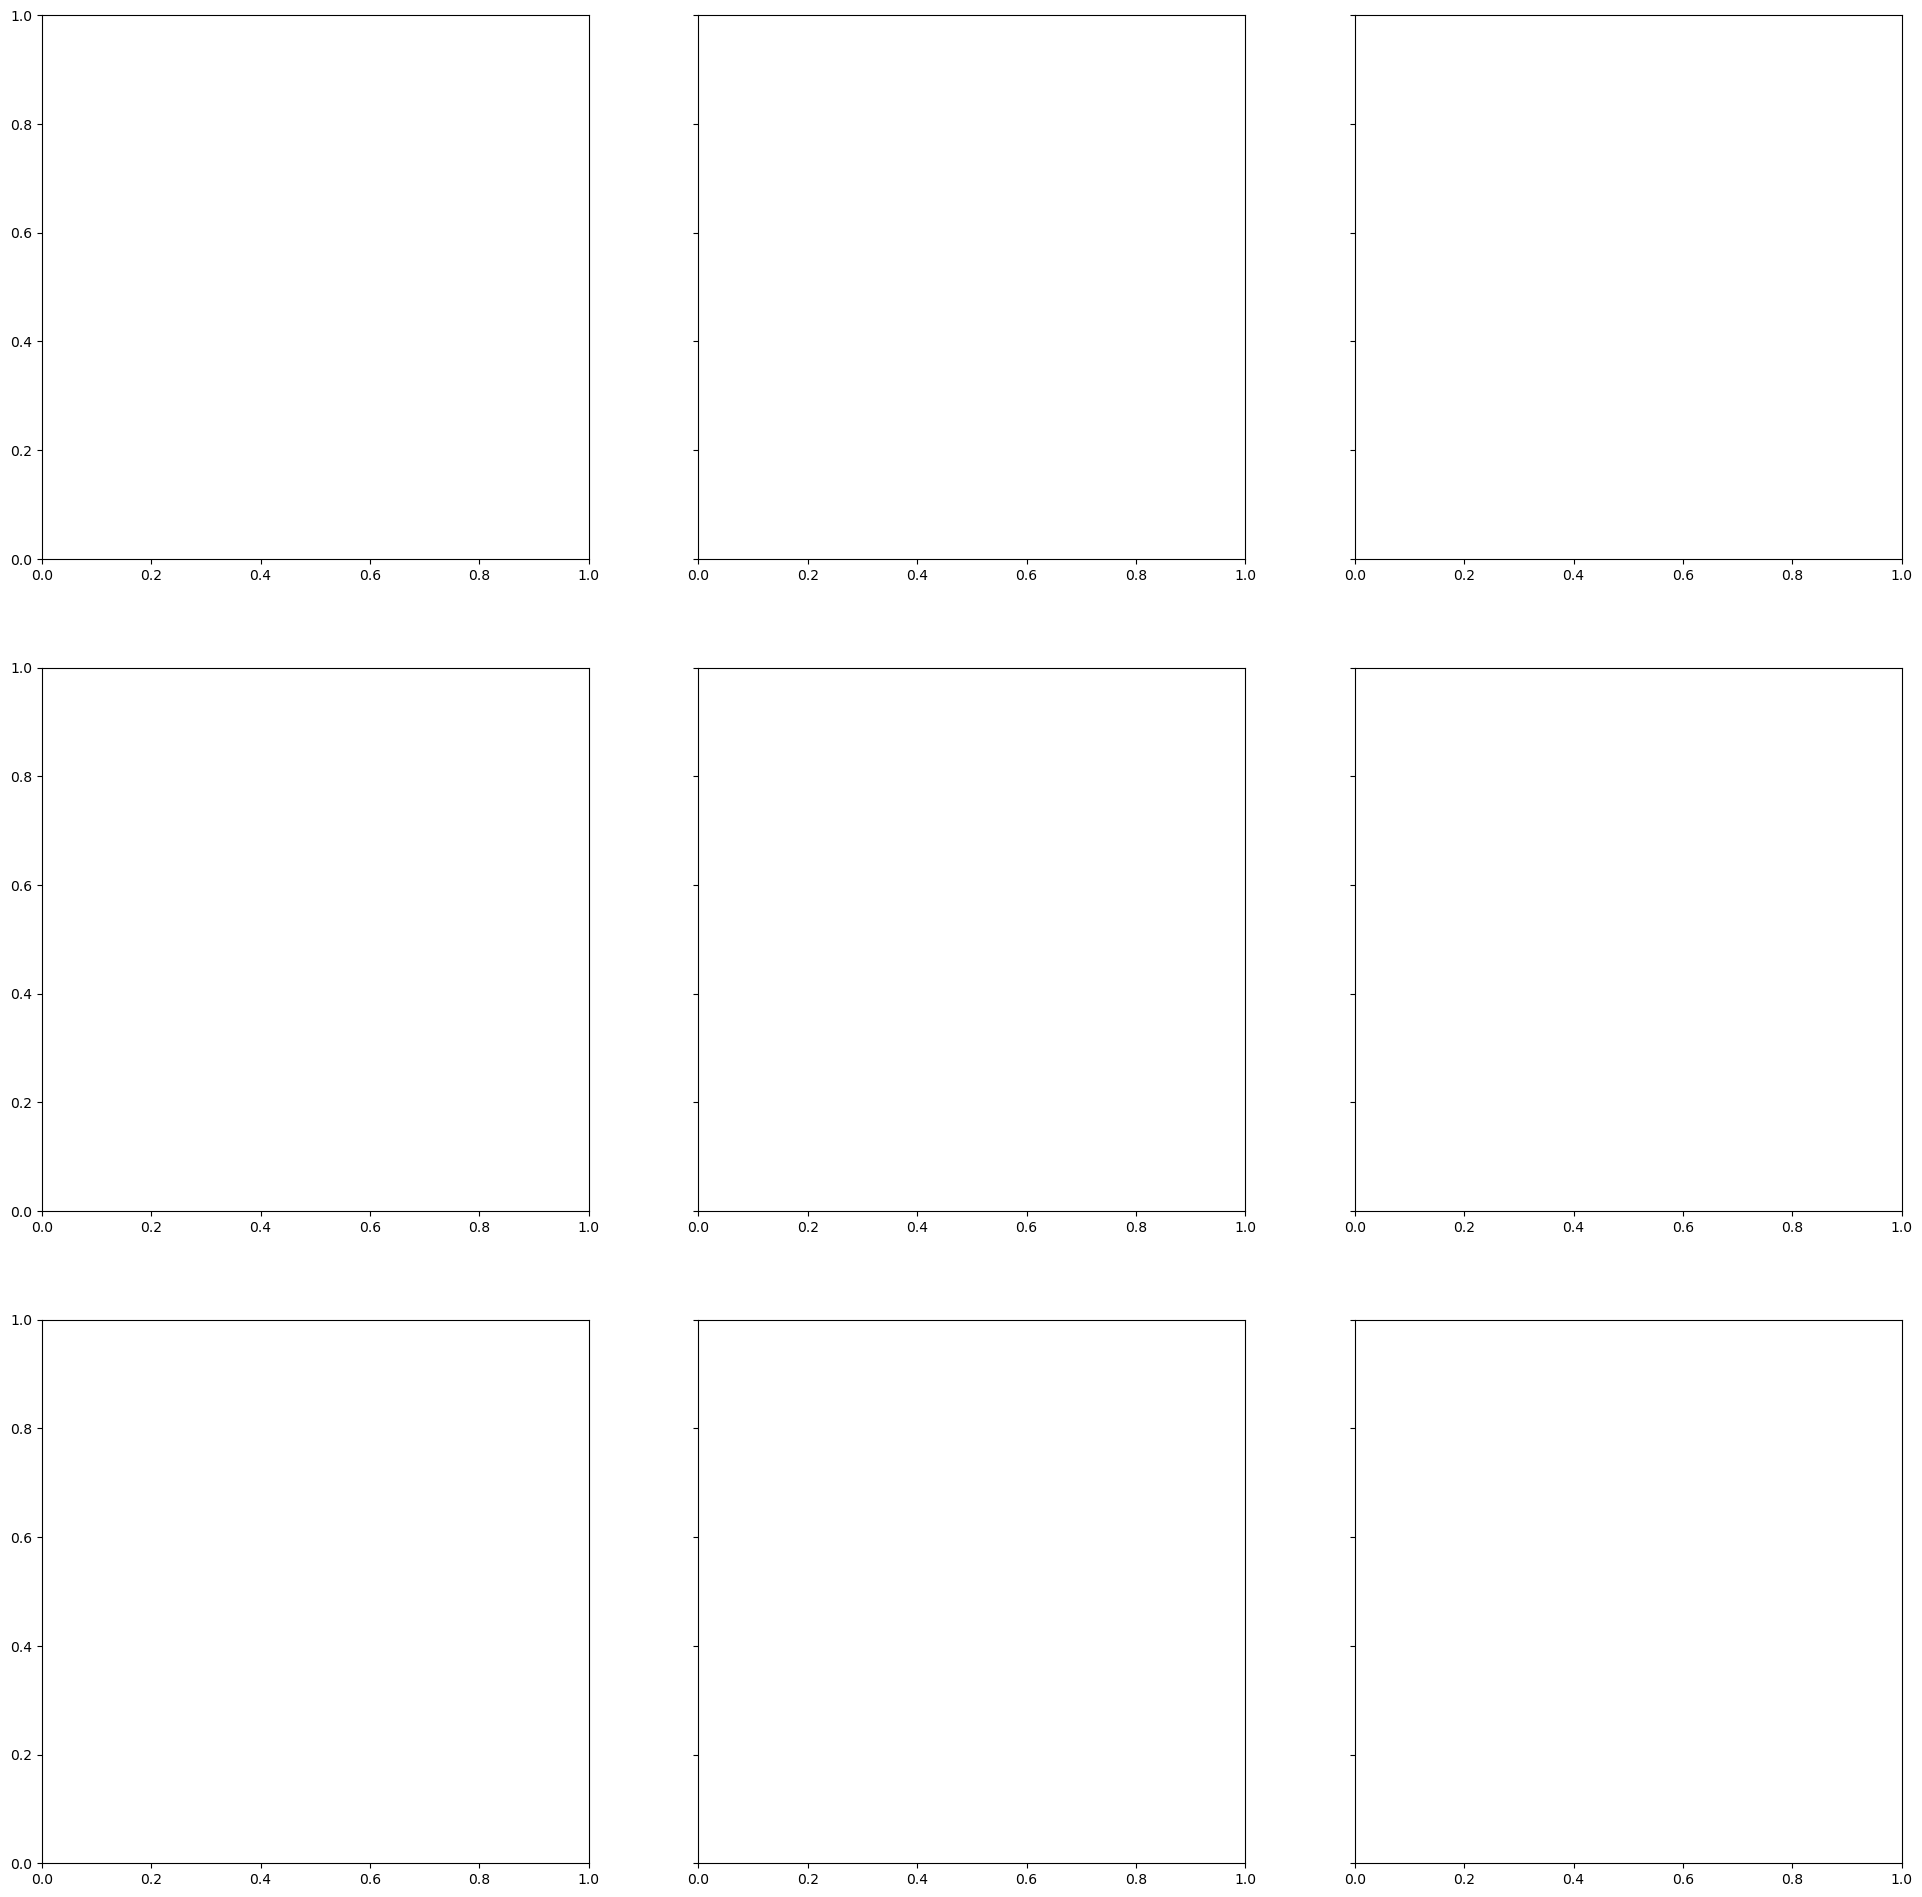

In [14]:
from matplotlib.animation import FuncAnimation
fig,axs = plt.subplots(3, 3, figsize=(24,24), sharey='row')

def update(frame):
    # Clear previous plot
    for ax in axs.flatten():
        ax.clear()

    # Get the dataset for the current frame
    benchmark = benchmark_list[frame]
    
    header_list=['_no_warmup_sleep','_warmup_sleep','_warmup_no_sleep']
    measure_list=['power','temp','util']
    ylabels=['Power (W)','Temperature (C)','GPU Utilization (%)']
    #I want to visualize the 5 runs for power
    for row, metric in enumerate(measure_list):
        min_y=np.inf
        max_y=-np.inf
        for header, ax in zip(header_list,axs[row]):
            all_benchmark_data = benchmark_dump[header]
            benchmark_data = all_benchmark_data[benchmark+header]
            for run in benchmark_data:
                power_values = run[metric]
                i = run['run']
                x_values = []
                y_values = []
                util_values = []
                for index, value in enumerate(power_values):
                    if value == -1:
                        ax.axvspan(index - 0.5, index + 0.5, facecolor='gray', alpha=0.3)
                    else:
                        x_values.append(index)
                        y_values.append(value)
                ax.scatter(x_values, y_values, label=f'Run {i}', marker='.')
                if len(y_values) != 0:
                    min_y = min(min_y,min(y_values))
                    max_y = max(max_y,max(y_values))
                if metric == 'util':
                    ax.axhline(y=95, color='black', linestyle="-")
    #             if 'util' in run:
    #                 # Add thin line scatter plot with utilization value

    #                 ax_right = ax.twinx()
    #                 util_values = run["util"]
    #                 if len(util_values) != len(x_values):
    #                     print(len(util_values), len(x_values))
    #                     util_values=[]
    #                     for index in x_values:
    #                         util_values.append(run["util"][index])
    #                 ax_right.scatter(x_values, util_values, color='yellow', marker='o', linestyle='-', linewidth=0.5)
    #                 ax_right.set_ylabel('Utilization (%)')
    #                 ax_right.set_ylim(0, 100)
            ax.legend()
            ax.set_title(benchmark+" "+header)
            ax.set_ylabel(ylabels[row])
            ax.set_xlabel("Sample Index")

        # Set y-axis limits based on the data
        margin = 0.05 * (max_y - min_y)  # 5% margin
        for ax in axs[row].flatten():
            ax.set_ylim(min_y - margin, max_y + margin)
            ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.tight_layout()

# animation = FuncAnimation(fig, update, frames=len(benchmark_list), interval=5000)
# animation.save('chart_animation.gif', writer='pillow')

# # Display the animation in the notebook
# plt.close(fig)
# from IPython.display import Image

# # Generate the animated GIF

# # Display the animation in the notebook
# Image(filename='chart_animation.gif')
    

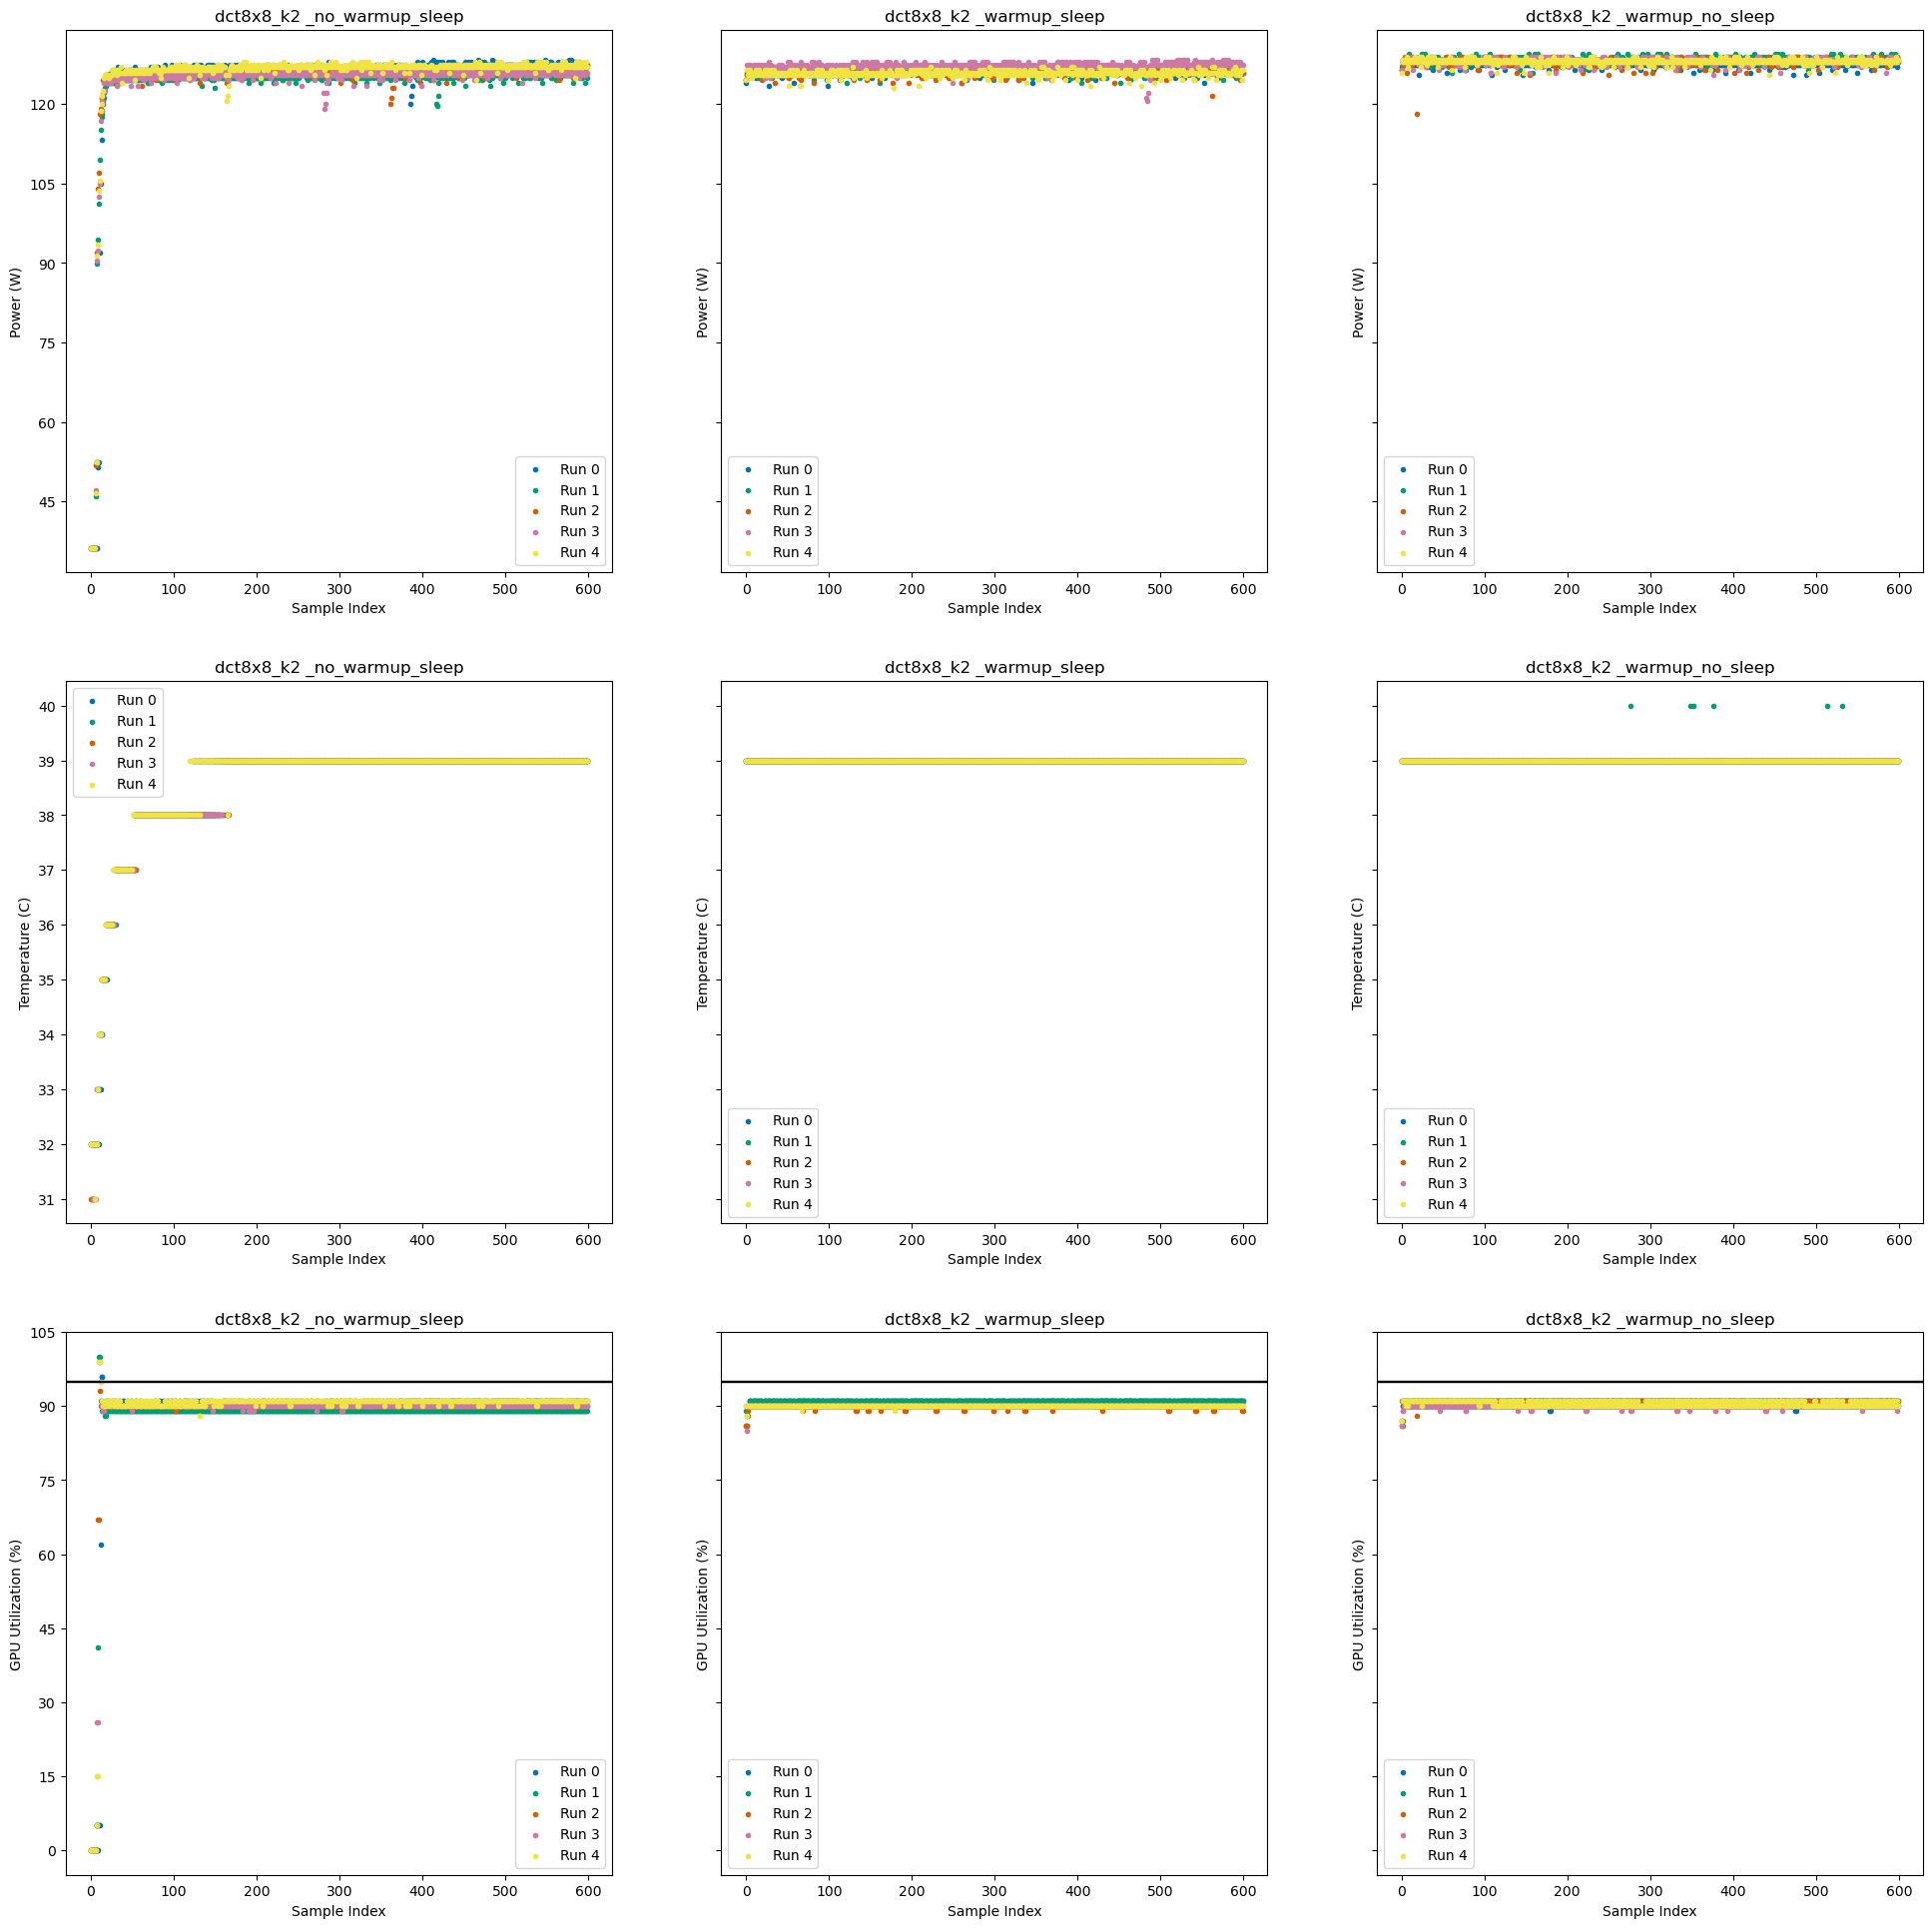

In [15]:

benchmark = "dct8x8_k2"
header_list=['_no_warmup_sleep','_warmup_sleep','_warmup_no_sleep'] #Cols
measure_list=['power','temp','util'] #Rows
ylabels=['Power (W)','Temperature (C)','GPU Utilization (%)']

fig,axs = plt.subplots(len(measure_list), len(header_list), figsize=(8*len(header_list),8*len(measure_list)), sharey='row')

#I want to visualize the 5 runs for power
for row, metric in enumerate(measure_list):
    min_y=np.inf
    max_y=-np.inf
    for header, ax in zip(header_list,axs[row]):
        all_benchmark_data = benchmark_dump[header]
        benchmark_data = all_benchmark_data[benchmark+header]
        for run in benchmark_data:
            power_values = run[metric]
            i = run['run']
            x_values = []
            y_values = []
            util_values = []
            for index, value in enumerate(power_values):
                if value == -1:
                    ax.axvspan(index - 0.5, index + 0.5, facecolor='gray', alpha=0.3)
                else:
                    x_values.append(index)
                    y_values.append(value)
            ax.scatter(x_values, y_values, label=f'Run {i}', marker='.')
            if len(y_values) != 0:
                min_y = min(min_y,min(y_values))
                max_y = max(max_y,max(y_values))
            if metric == 'util':
                ax.axhline(y=95, color='black', linestyle="-")
#             if 'util' in run:
#                 # Add thin line scatter plot with utilization value

#                 ax_right = ax.twinx()
#                 util_values = run["util"]
#                 if len(util_values) != len(x_values):
#                     print(len(util_values), len(x_values))
#                     util_values=[]
#                     for index in x_values:
#                         util_values.append(run["util"][index])
#                 ax_right.scatter(x_values, util_values, color='yellow', marker='o', linestyle='-', linewidth=0.5)
#                 ax_right.set_ylabel('Utilization (%)')
#                 ax_right.set_ylim(0, 100)
        ax.legend()
        ax.set_title(benchmark+" "+header)
        ax.set_ylabel(ylabels[row])
        ax.set_xlabel("Sample Index")

    # Set y-axis limits based on the data
    margin = 0.05 * (max_y - min_y)  # 5% margin
    for ax in axs[row].flatten():
        ax.set_ylim(min_y - margin, max_y + margin)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.tight_layout()
# #plt.show()    

In [16]:
type(benchmark_external_temps)#Dict
benchmark_external_temps.keys()#benchmark_no_warmup_sleep
bad_run='cutlass_k3_warmup_no_sleep'
benchmark_external_temps[bad_run]

[(37, 44), (37, 43), (37, 44), (37, 44), (37, 44)]

<h1>No Sleep vs Sleep</h1>

In [17]:
Colors="""dimgray
#696969
saddlebrown
#8b4513
midnightblue
#191970
olive
#808000
green
#008000
yellowgreen
#9acd32
darkseagreen
#8fbc8f
darkmagenta
#8b008b
red
#ff0000
darkturquoise
#00ced1
orange
#ffa500
yellow
#ffff00
lawngreen
#7cfc00
mediumspringgreen
#00fa9a
blueviolet
#8a2be2
royalblue
#4169e1
crimson
#dc143c
deepskyblue
#00bfff
blue
#0000ff
thistle
#d8bfd8
fuchsia
#ff00ff
palevioletred
#db7093
khaki
#f0e68c
deeppink
#ff1493
lightsalmon
#ffa07a
violet
#ee82ee"""
colors = [color for color in Colors.split("\n") if color.startswith('#')]                                                                
# import random
# random.shuffle(colors)


In [18]:
#Start by looking at the external readings
#The initial reading
sleep_benchmark_temps = {}
no_sleep_benchmark_temps = {}
for benchmark_set in benchmark_external_temps:
    if '_no_' not in benchmark_set:
        sleep_benchmark_temps[benchmark_set] = benchmark_external_temps[benchmark_set]
    if 'no_sleep' in benchmark_set:
        no_sleep_benchmark_temps[benchmark_set] = benchmark_external_temps[benchmark_set]
        
        
# sleep_benchmark_temps

In [19]:
len(sleep_benchmark_temps)

26

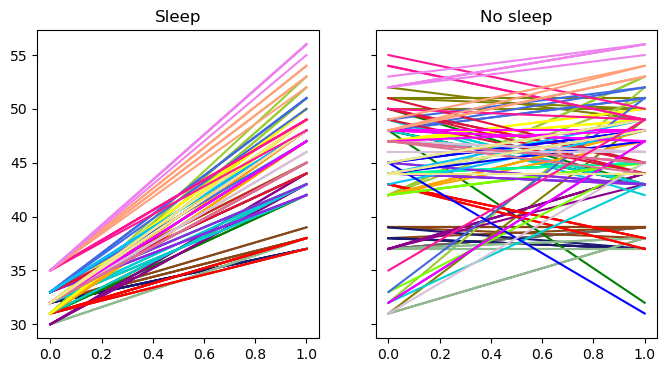

In [20]:
fig,axs = plt.subplots(1, 2, figsize=(8,4), sharey='row')
header_list = [sleep_benchmark_temps,no_sleep_benchmark_temps]
#I want to visualize the 5 runs for power
for header, ax in zip(header_list,axs):
    for benchmark, color in zip(header,colors):
        for index,run in enumerate(header[benchmark]):
            # print(benchmark,run)            
            # if run[0] > run[1]:
            #     print("Benchmark is weird",benchmark,index)
            # else:
            if run != (-1,-1):
                ax.plot(range(len(run)), run, color=color)
        ax.set_title("Sleep" if header_list.index(header) == 0 else "No sleep")
#plt.show()    

In [21]:
#As you can see, no sleep is definitely something else
#NOTE: the Initial temp is measured BEFORE the application is EXECUTED, rather than before the profile begins (i.e., this does not show how hot things get with warmup)
#Q. How does the first run of no_sleep compare to the sleep column?
# Is it sufficient to throw away the first column of no_sleep since the opearting tempeartures is roughly the same?

In [22]:
first_benchmarks="""backprop_k1
btree_k1
dct8x8_k1
cutlass_k2
fastWalshTransform_k2
kmeans_k1
parboil_mriq_k1
pathfinder_k1
sobolQRNG_k1"""
first_benchmarks_list = first_benchmarks.split('\n')
first_benchmarks_list

['backprop_k1',
 'btree_k1',
 'dct8x8_k1',
 'cutlass_k2',
 'fastWalshTransform_k2',
 'kmeans_k1',
 'parboil_mriq_k1',
 'pathfinder_k1',
 'sobolQRNG_k1']

In [23]:
other_benchmark_list = list(set(benchmark_list) - set(first_benchmarks_list))
other_benchmark_list

['srad_v1_k1',
 'binomialOptions_k1',
 'fastWalshTransform_k1',
 'parboil_sgemm_k1',
 'quasirandomGenerator_k1',
 'mergeSort_k2',
 'hotspot_k1',
 'histogram_k1',
 'parboil_sad_k1',
 'backprop_k2',
 'cutlass_k3',
 'cudaTensorCoreGemm_k1',
 'cutlass_k1',
 'dct8x8_k2',
 'mergeSort_k1',
 'btree_k2',
 'quasirandomGenerator_k2']

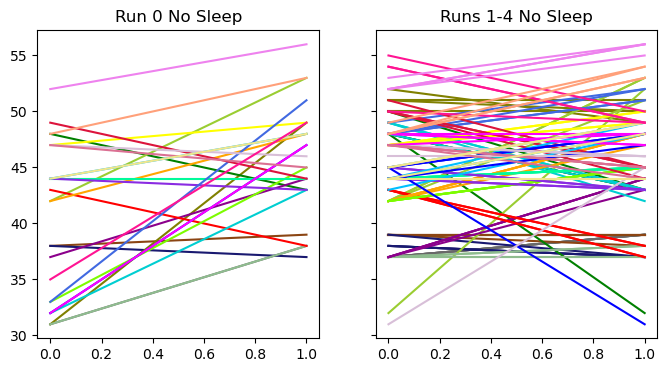

In [24]:
fig,axs = plt.subplots(1, 2, figsize=(8,4), sharey='row')
for ax,run_nums in zip(axs,[[0],range(1,5)]):
    for benchmark, color in zip(no_sleep_benchmark_temps,colors):
        for index in run_nums:
            run = no_sleep_benchmark_temps[benchmark][index]
            if run != (-1,-1):
                ax.plot(range(len(run)), run, color=color)
    ax.set_title("Run 0 No Sleep" if run_nums == [0] else "Runs 1-4 No Sleep")
#plt.show() 

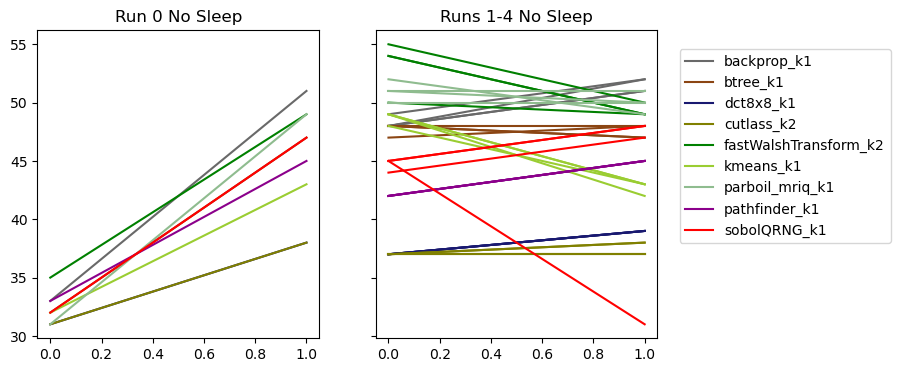

In [25]:
#Really the way that we do things makes it so that the first benchmark in a set will suffer the symptoms
fig,axs = plt.subplots(1, 2, figsize=(8,4), sharey='row')
for ax,run_nums in zip(axs,[[0],range(1,5)]):
    for benchmark, color in zip(first_benchmarks_list,colors):
        for index in run_nums:
            run = no_sleep_benchmark_temps[benchmark+"_warmup_no_sleep"][index]
            if run != (-1,-1):
                ax.plot(range(len(run)), run, color=color)
    ax.set_title("Run 0 No Sleep" if run_nums == [0] else "Runs 1-4 No Sleep")
fig.legend(first_benchmarks_list, loc="upper right",bbox_to_anchor=(1.2,0.85))
#plt.show() 

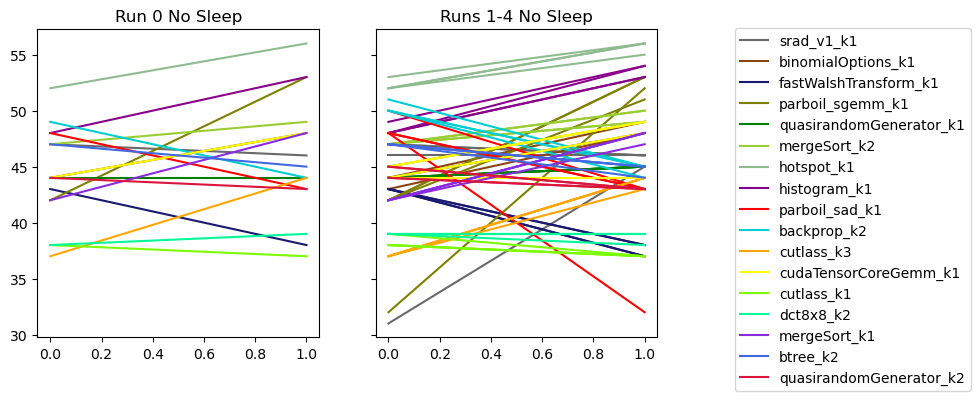

In [26]:
#Really the way that we do things makes it so that the first benchmark in a set will suffer the symptoms
fig,axs = plt.subplots(1, 2, figsize=(8,4), sharey='row')
for ax,run_nums in zip(axs,[[0],range(1,5)]):
    for benchmark, color in zip(other_benchmark_list,colors):
        for index in run_nums:
            run = no_sleep_benchmark_temps[benchmark+"_warmup_no_sleep"][index]
            if run != (-1,-1):
                ax.plot(range(len(run)), run, color=color)
    ax.set_title("Run 0 No Sleep" if run_nums == [0] else "Runs 1-4 No Sleep")
fig.legend(other_benchmark_list, loc="upper right",bbox_to_anchor=(1.3,0.9))
#plt.show() 

In [27]:
#So external measurements definitely follow the story I'm putting down. Let's see how the internal temperature power look
#Lets start by plotting all of the sleep against all of the no sleep

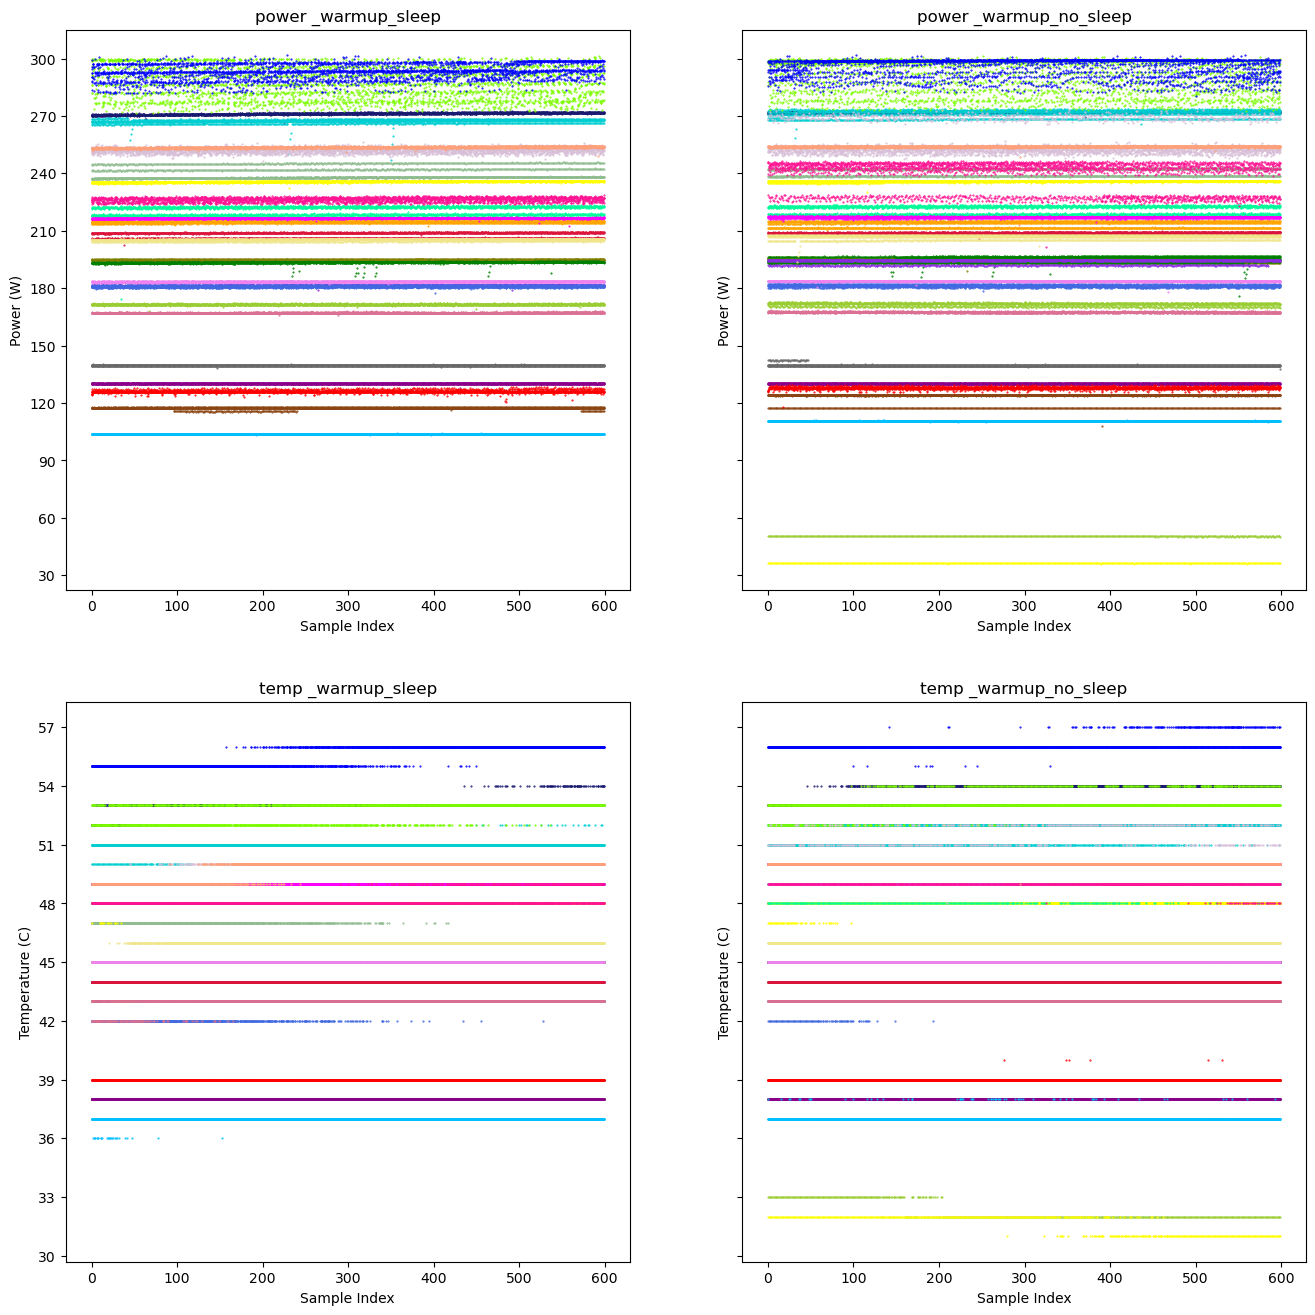

In [28]:

header_list=['_warmup_sleep','_warmup_no_sleep']
measure_list=['power','temp']
ylabels=['Power (W)','Temperature (C)','GPU Utilization (%)']
fig,axs = plt.subplots(len(measure_list), len(header_list), figsize=(8*len(header_list),8*len(measure_list)), sharey='row')

#Each metric (row)
for row, metric in enumerate(measure_list):
    min_y=np.inf
    max_y=-np.inf
    #Each setup (column)
    for header, ax in zip(header_list,axs[row]):
        all_benchmark_data = benchmark_dump[header]
        for benchmark,color in zip(benchmark_list,colors):
            benchmark_data = benchmark_dump[header][benchmark+header]
            for run in benchmark_data:
                power_values = run[metric]
                i = run['run']
                x_values = []
                y_values = []
                util_values = []
                for index, value in enumerate(power_values):
                    if value == -1:
                        ax.axvspan(index - 0.5, index + 0.5, facecolor='gray', alpha=0.3)
                    else:
                        x_values.append(index)
                        y_values.append(value)
                ax.scatter(x_values, y_values, marker='.', color=color,s=(1))
                if len(y_values) != 0:
                    min_y = min(min_y,min(y_values))
                    max_y = max(max_y,max(y_values))
                if metric == 'util':
                    ax.axhline(y=95, color='black', linestyle="-")
        ax.set_title(metric+" "+header)
        ax.set_ylabel(ylabels[row])
        ax.set_xlabel("Sample Index")

    # Set y-axis limits based on the data
    margin = 0.05 * (max_y - min_y)  # 5% margin
    for ax in axs[row].flatten():
        ax.set_ylim(min_y - margin, max_y + margin)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
#plt.show()    

In [29]:
#Yeah, the data above is really too much and is hard to read...

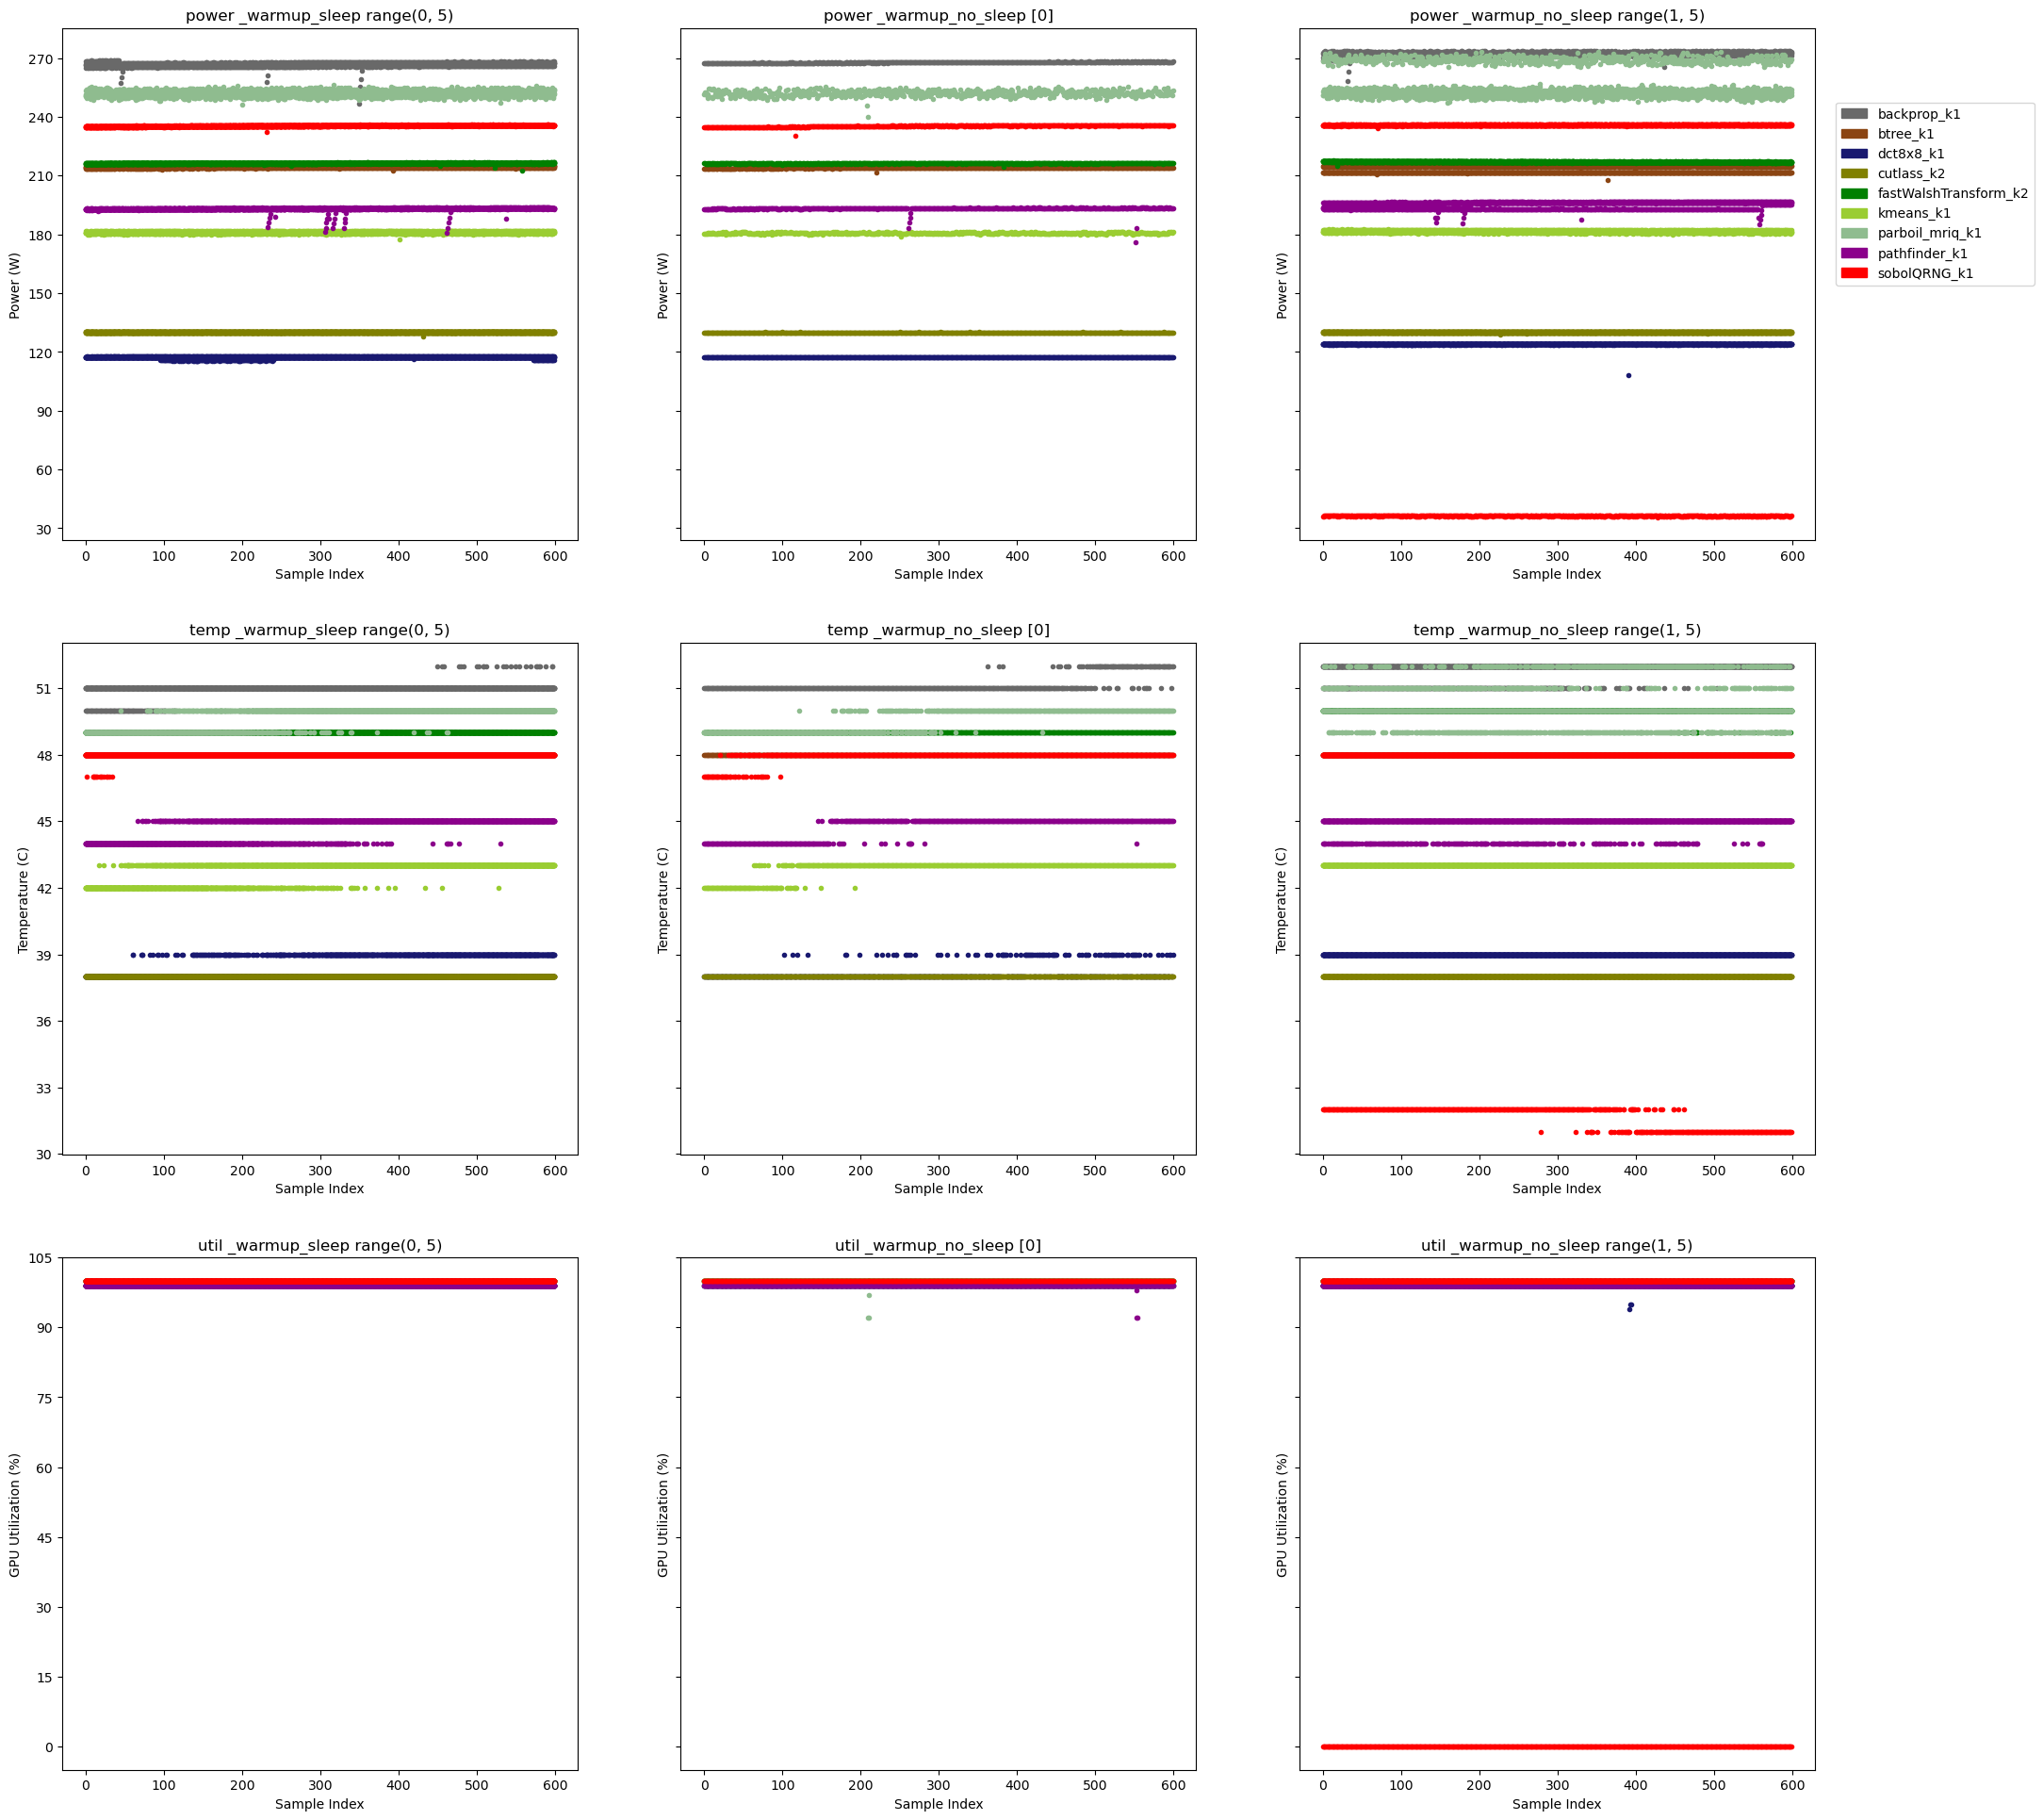

In [30]:
import matplotlib.patches as mpatches

#Focus on only the first_benchmark_list
header_list=[{"_warmup_sleep":range(5)},{"_warmup_no_sleep":[0]},{"_warmup_no_sleep":range(1,5)}]
measure_list=['power','temp','util']
ylabels=['Power (W)','Temperature (C)','GPU Utilization (%)']
fig,axs = plt.subplots(len(measure_list), len(header_list), figsize=(8*len(header_list),8*len(measure_list)), sharey='row')
legend_patches=[]
for benchmark,color in zip(first_benchmarks_list,colors):
    legend_patches.append( mpatches.Patch(color=color,label=benchmark))

#Each metric (row)
for row, metric in enumerate(measure_list):
    min_y=np.inf
    max_y=-np.inf
    #Each setup (column)
    for header_dict, ax in zip(header_list,axs[row]):
        (header,run_nums), = header_dict.items()
        all_benchmark_data = benchmark_dump[header]
        for benchmark,color in zip(first_benchmarks_list,colors):
            benchmark_data = benchmark_dump[header][benchmark+header]
            for run in benchmark_data:
                power_values = run[metric]
                i = run['run']
                x_values = []
                y_values = []
                util_values = []
                if i not in run_nums:
                    continue
                for index, value in enumerate(power_values):
                    if value == -1:
                        ax.axvspan(index - 0.5, index + 0.5, facecolor='gray', alpha=0.3)
                    else:
                        x_values.append(index)
                        y_values.append(value)
                ax.scatter(x_values, y_values, marker='.', color=color,s=36)
                if len(y_values) != 0:
                    min_y = min(min_y,min(y_values))
                    max_y = max(max_y,max(y_values))
        ax.set_title(metric+" "+header+" "+str(run_nums))
        ax.set_ylabel(ylabels[row])
        ax.set_xlabel("Sample Index")

    # Set y-axis limits based on the data
    margin = 0.05 * (max_y - min_y)  # 5% margin
    for ax in axs[row].flatten():
        ax.set_ylim(min_y - margin, max_y + margin)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1,0.85),markerscale=10)
#plt.show()

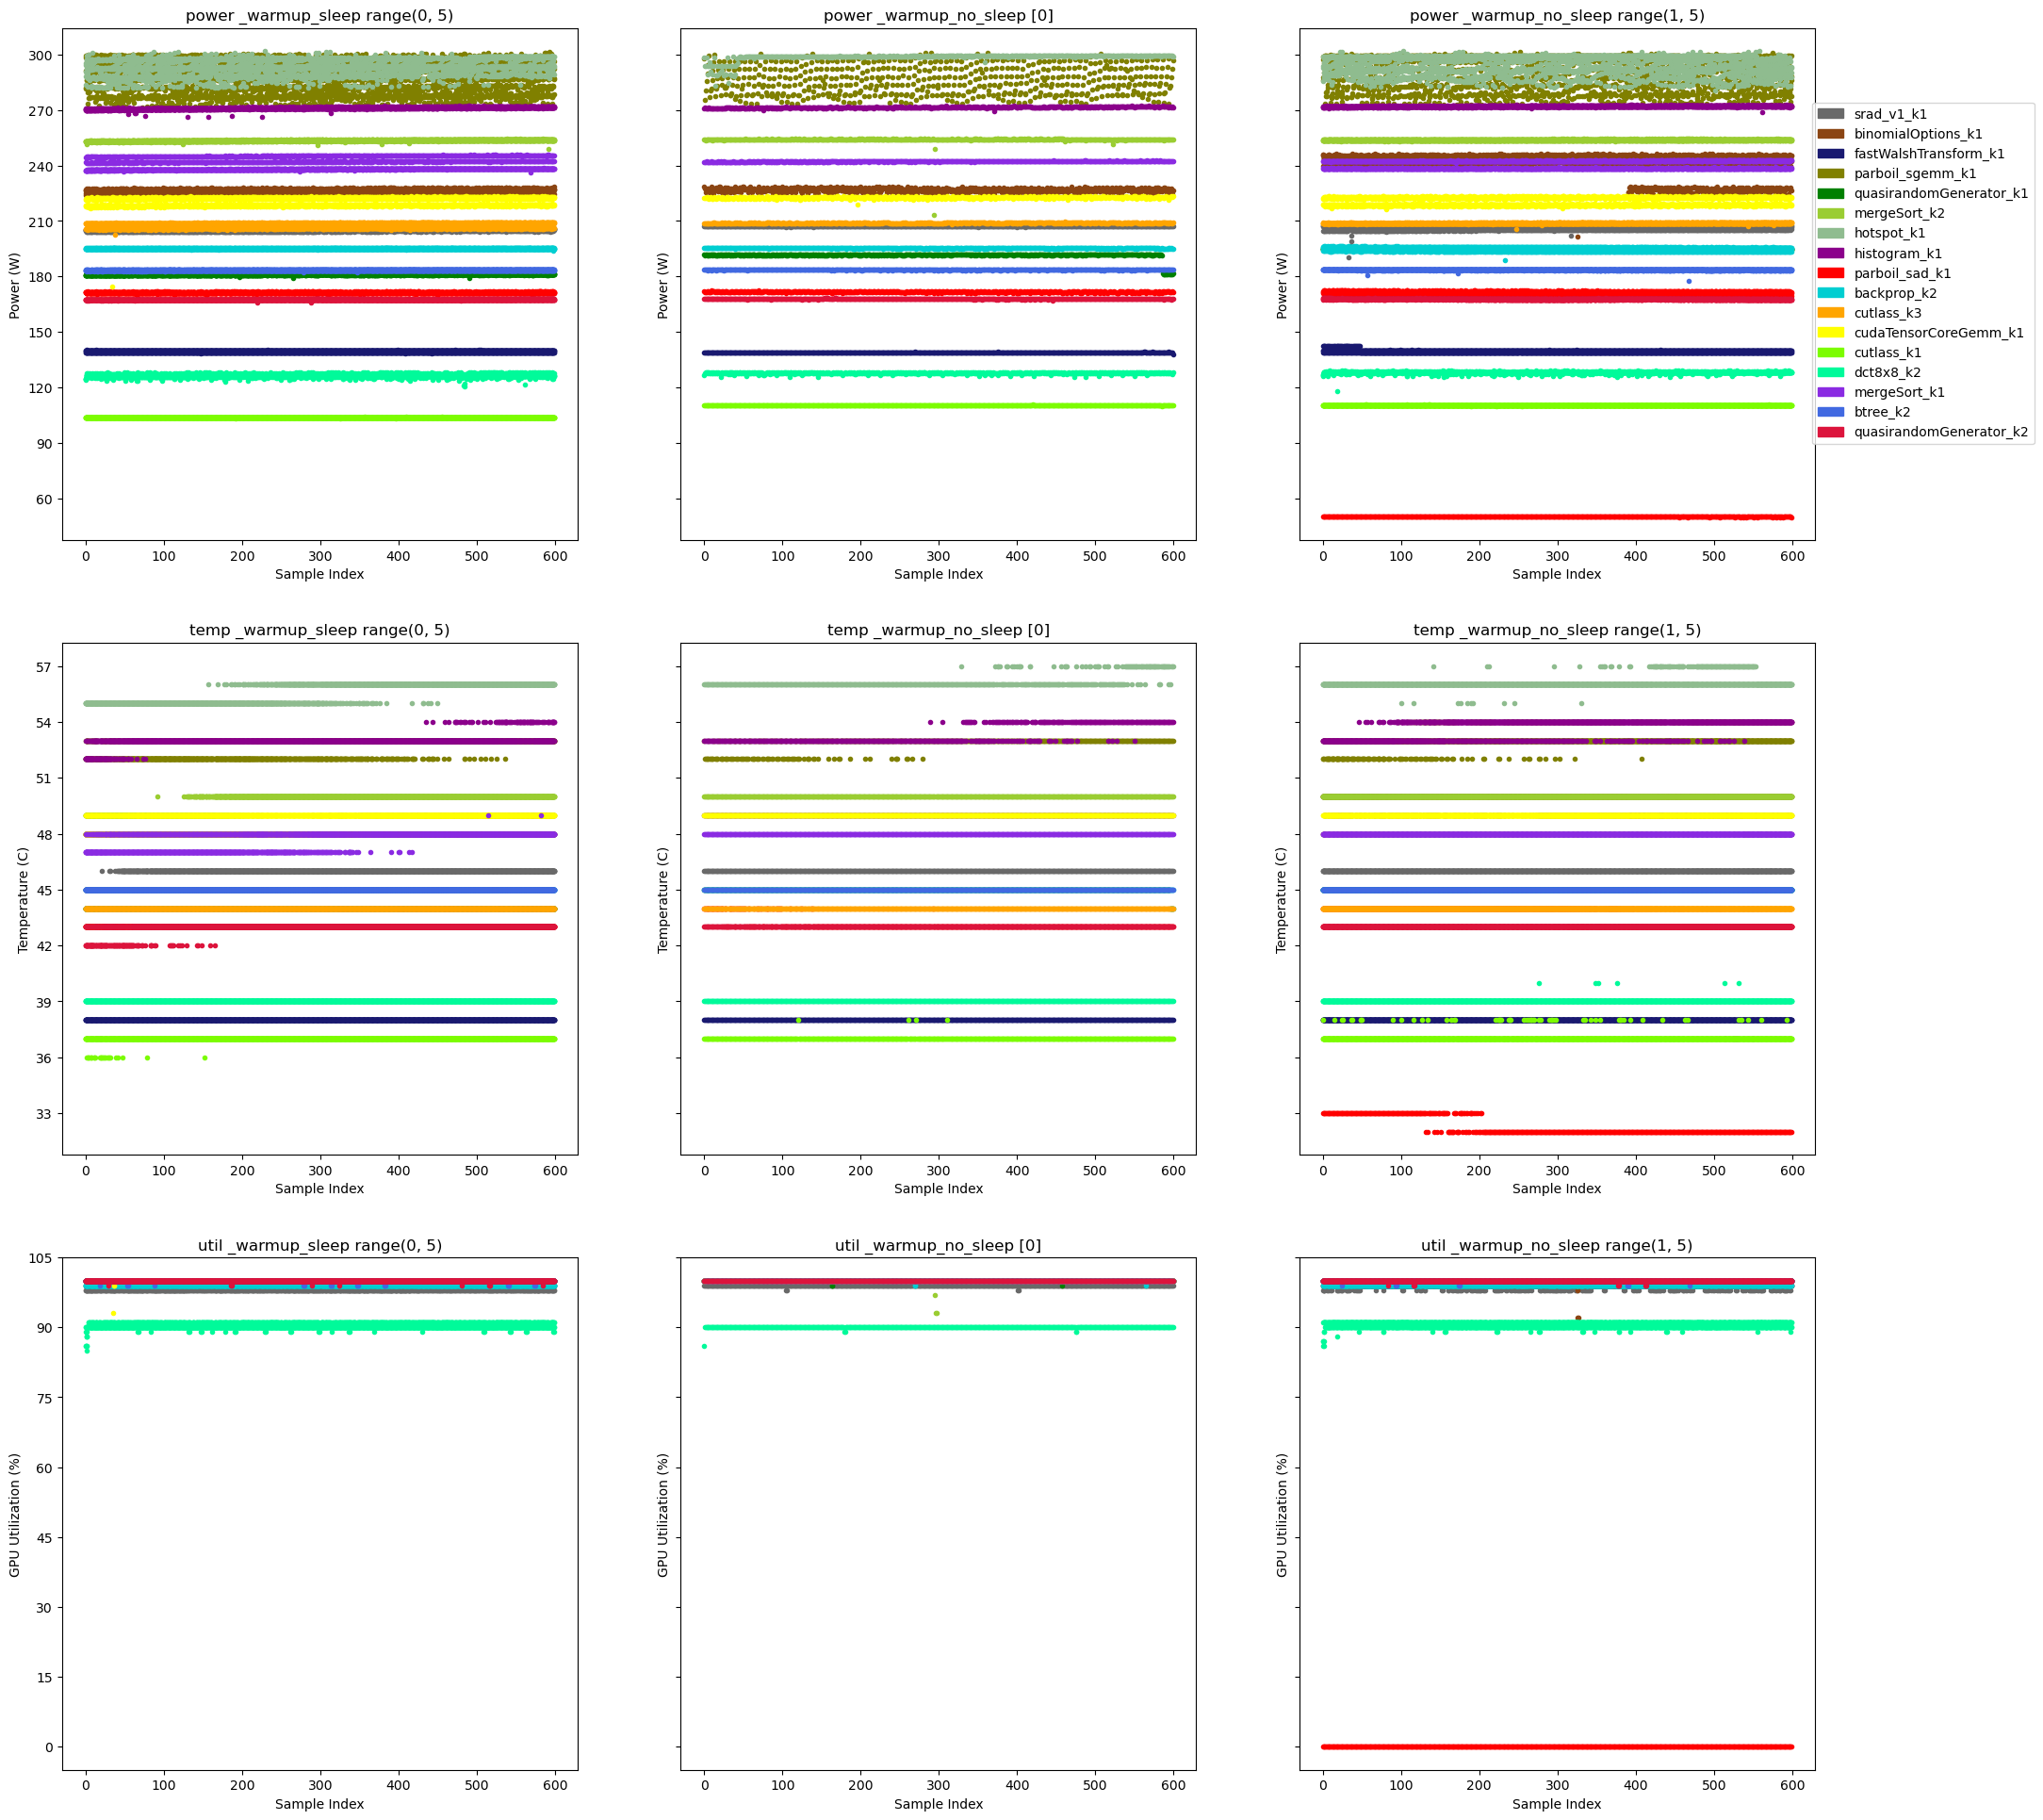

In [31]:
#Let's look at all the other benchmarks
header_list=[{"_warmup_sleep":range(5)},{"_warmup_no_sleep":[0]},{"_warmup_no_sleep":range(1,5)}]
measure_list=['power','temp','util']
ylabels=['Power (W)','Temperature (C)','GPU Utilization (%)']
fig,axs = plt.subplots(len(measure_list), len(header_list), figsize=(8*len(header_list),8*len(measure_list)), sharey='row')
legend_patches=[]
for benchmark,color in zip(other_benchmark_list,colors):
    legend_patches.append( mpatches.Patch(color=color,label=benchmark))

#Each metric (row)
for row, metric in enumerate(measure_list):
    min_y=np.inf
    max_y=-np.inf
    #Each setup (column)
    for header_dict, ax in zip(header_list,axs[row]):
        (header,run_nums), = header_dict.items()
        all_benchmark_data = benchmark_dump[header]
        for benchmark,color in zip(other_benchmark_list,colors):
            benchmark_data = benchmark_dump[header][benchmark+header]
            for run in benchmark_data:
                power_values = run[metric]
                i = run['run']
                x_values = []
                y_values = []
                util_values = []
                if i not in run_nums:
                    continue
                for index, value in enumerate(power_values):
                    if value == -1:
                        ax.axvspan(index - 0.5, index + 0.5, facecolor='gray', alpha=0.3)
                    else:
                        x_values.append(index)
                        y_values.append(value)
                ax.scatter(x_values, y_values, marker='.', color=color,s=36)
                if len(y_values) != 0:
                    min_y = min(min_y,min(y_values))
                    max_y = max(max_y,max(y_values))
        ax.set_title(metric+" "+header+" "+str(run_nums))
        ax.set_ylabel(ylabels[row])
        ax.set_xlabel("Sample Index")

    # Set y-axis limits based on the data
    margin = 0.05 * (max_y - min_y)  # 5% margin
    for ax in axs[row].flatten():
        ax.set_ylim(min_y - margin, max_y + margin)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1,0.85),markerscale=10)
#plt.show()

In conclusion. The difference between sleep and no sleep is minor at best. The main takeaway when zooming out is that having a warmup significantly mitigates issues that we were experiencing. Introducing the sleep also serves as a way to resolve issues with getting 0 utilization due to crowding the GPU.

<h1>Aggregating Data Values</h1>

In [32]:
#Lets start with determining min max things

In [33]:
min_power = np.inf
max_power = -np.inf
min_temp = np.inf
max_temp = -np.inf

for k,v in benchmark_dump.items():
    for benchmark,benchmark_data in v.items():
        for run in benchmark_data:
            if run['power'] == [] or run['temp'] == []:
                continue
            min_power = min(min_power,min(run['power']))
            max_power = max(max_power,max(run['power']))
            min_temp = min(min_temp,min(run['temp']))
            max_temp = max(max_temp,max(run['temp']))
print(min_power,max_power,min_temp,max_temp)

35.274 302.229 30 57


In [34]:
benchmark_dump['_warmup_sleep'].keys()

dict_keys(['pathfinder_k1_warmup_sleep', 'binomialOptions_k1_warmup_sleep', 'hotspot_k1_warmup_sleep', 'btree_k1_warmup_sleep', 'cudaTensorCoreGemm_k1_warmup_sleep', 'cutlass_k2_warmup_sleep', 'backprop_k1_warmup_sleep', 'quasirandomGenerator_k1_warmup_sleep', 'kmeans_k1_warmup_sleep', 'parboil_sad_k1_warmup_sleep', 'backprop_k2_warmup_sleep', 'histogram_k1_warmup_sleep', 'quasirandomGenerator_k2_warmup_sleep', 'dct8x8_k2_warmup_sleep', 'mergeSort_k2_warmup_sleep', 'srad_v1_k1_warmup_sleep', 'dct8x8_k1_warmup_sleep', 'btree_k2_warmup_sleep', 'mergeSort_k1_warmup_sleep', 'fastWalshTransform_k2_warmup_sleep', 'sobolQRNG_k1_warmup_sleep', 'parboil_mriq_k1_warmup_sleep', 'cutlass_k1_warmup_sleep', 'fastWalshTransform_k1_warmup_sleep', 'parboil_sgemm_k1_warmup_sleep', 'cutlass_k3_warmup_sleep'])

In [35]:
#With warmup_sleep and warmup_no_sleep clearly doing better in terms of
#getting steady state power consumption of an application,
#let's consider the power/temperature factor. Given having no_sleep typically has higher power/temp

benchmark_dump.keys()
for benchmark in benchmark_dump['_warmup_sleep']:
    benchmark_data = benchmark_dump['_warmup_sleep'][benchmark]
    for run in benchmark_data:
        if sum(run['temp']) == 0:
            print(benchmark, run)
        # print(benchmark,"Power", sum(run['power']),"Temp", sum(run['temp']),"Factor",sum(run['power'])/sum(run['temp']))


<h1>Calculated Measured Power</h1>

In [36]:
#We just want to create a simple CSV file that lists the kernel's name as the index and the measured power in Watts
#The measured power is simply going to be the average power from our warmup/sleep run
#From the averaged power, then we will average the power again between the five runs of our setup

# benchmark_dump['_warmup_sleep']

In [37]:
collated_data_list = []
for benchmark_set, benchmark_data_list in benchmark_dump['_warmup_sleep'].items():
    collated_benchmark_dict = {}
    collated_benchmark_dict['benchmark'] = benchmark_set.replace('_warmup_sleep','')
    collated_benchmark_dict['avg_power_list'] = []
    collated_benchmark_dict['avg_temp_list'] = []
    for run_dict in benchmark_data_list:
        if len(run_dict['power']) == 0:
            collated_benchmark_dict['avg_power_list'].append(0)
        else:
            collated_benchmark_dict['avg_power_list'].append(sum(run_dict['power'])/len(run_dict['power']))
        if len(run_dict['temp']) == 0:
            collated_benchmark_dict['avg_temp_list'].append(0)
        else:
            collated_benchmark_dict['avg_temp_list'].append(sum(run_dict['temp'])/len(run_dict['temp']))

    collated_data_list.append(collated_benchmark_dict)
collated_data_list

[{'benchmark': 'pathfinder_k1',
  'avg_power_list': [193.29856499999983,
   193.48244666666605,
   193.21677666666673,
   193.1764683333332,
   193.2541783333331],
  'avg_temp_list': [44.76833333333333,
   44.83,
   44.47666666666667,
   44.516666666666666,
   44.67333333333333]},
 {'benchmark': 'binomialOptions_k1',
  'avg_power_list': [226.178771666666,
   226.40522666666604,
   226.54753499999939,
   226.57805499999938,
   226.5938866666662],
  'avg_temp_list': [48.0,
   48.0,
   48.038333333333334,
   48.266666666666666,
   48.28333333333333]},
 {'benchmark': 'hotspot_k1',
  'avg_power_list': [292.8084833333327,
   292.85577833333303,
   293.5924200000016,
   293.95991666666873,
   292.7119049999995],
  'avg_temp_list': [55.66, 55.585, 55.461666666666666, 55.56, 55.48]},
 {'benchmark': 'btree_k1',
  'avg_power_list': [214.4439083333302,
   214.52710999999724,
   214.95802999999833,
   213.9486300000023,
   214.95237499999845],
  'avg_temp_list': [48.0, 48.0, 48.0, 48.0, 48.0]},
 {'

In [38]:
measured_power_dict = {}
for benchmark_dict in collated_data_list:
    measured_power_dict[benchmark_dict['benchmark']] = {}
    datapoints = np.array(benchmark_dict['avg_power_list'])
    measured_power_dict[benchmark_dict['benchmark']]["pwr_measured_HW_avg"] = datapoints.mean()
    measured_power_dict[benchmark_dict['benchmark']]["pwr_st_dev"] = datapoints.std()
    measured_power_dict[benchmark_dict['benchmark']]["pwr_var"] = datapoints.var()
    measured_power_dict[benchmark_dict['benchmark']]["pwr_#samples"] = datapoints.size
    datapoints = np.array(benchmark_dict['avg_temp_list'])
    measured_power_dict[benchmark_dict['benchmark']]["tmp_measured_HW_avg"] = datapoints.mean()
    measured_power_dict[benchmark_dict['benchmark']]["tmp_st_dev"] = datapoints.std()
    measured_power_dict[benchmark_dict['benchmark']]["tmp_var"] = datapoints.var()
    measured_power_dict[benchmark_dict['benchmark']]["tmp_#samples"] = datapoints.size

    
    measured_power_df = pd.DataFrame.from_dict(measured_power_dict, orient='index')
measured_power_df.head()


,pwr_measured_HW_avg,pwr_st_dev,pwr_var,pwr_#samples,tmp_measured_HW_avg,tmp_st_dev,tmp_var,tmp_#samples
pathfinder_k1,193.285687,0.106349,0.011310,5,44.653000,0.137640,0.018945,5
binomialOptions_k1,226.460695,0.155956,0.024322,5,48.117667,0.129330,0.016726,5
hotspot_k1,293.185701,0.498087,0.248091,5,55.549333,0.072285,0.005225,5
btree_k1,214.566011,0.374309,0.140108,5,48.000000,0.000000,0.000000,5
cudaTensorCoreGemm_k1,220.681354,1.857918,3.451858,5,48.753333,0.265801,0.070650,5


In [39]:
results_dir = os.path.join(os.getcwd(),'accelwattch_results')
output_filename = 'hw_power_results.csv'
measured_power_df.to_csv(os.path.join(results_dir,output_filename))